# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# number of training examples
n_train = len(y_train)

# number of testing examples
n_test = len(y_test)

# what's the shape of an image?
image_shape = train['features'][0].shape

# how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


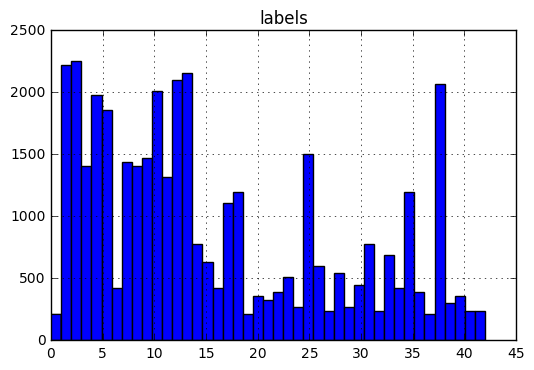

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]
mean label count:  911.837209302
median label count:  600.0


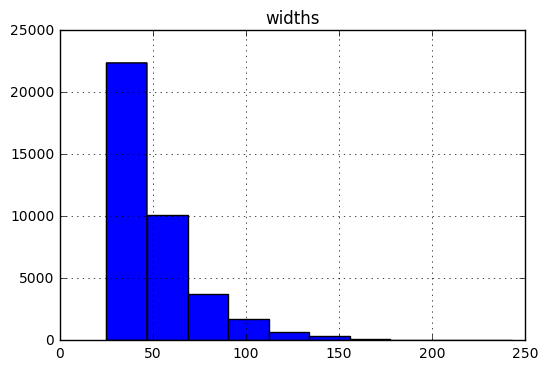

min image width 25
max image width 243



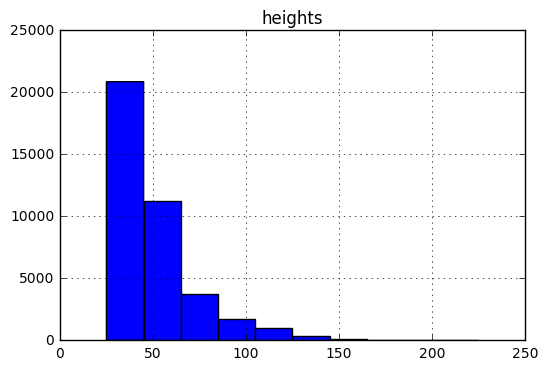

min image height 25
max image height 225

There doesn't seem to be much reason to have the coords of the feature in the original image at this point...

Example image with feature called out: 
location:  [ 5  6 24 25]
type:  0


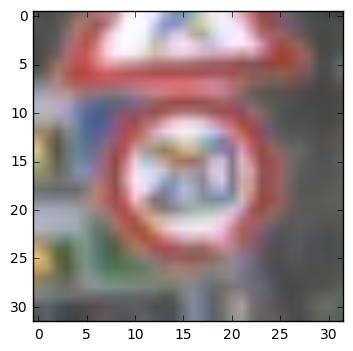


Example image with feature called out: 
location:  [ 6  6 28 29]
type:  4


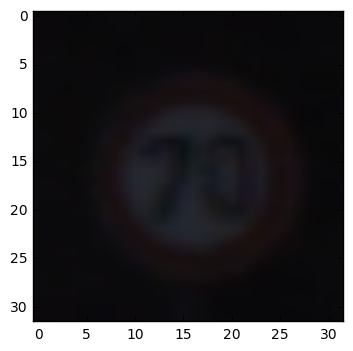


Example image with feature called out: 
location:  [ 5  5 39 38]
type:  10


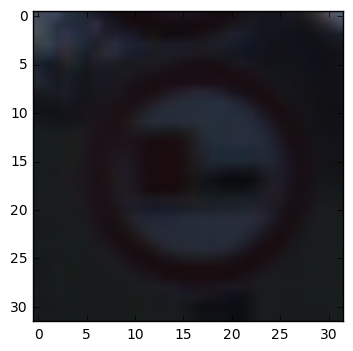


Example image with feature called out: 
location:  [ 5  5 22 23]
type:  15


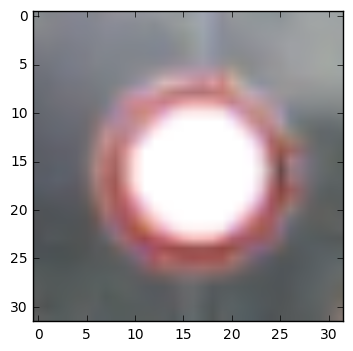


Example image with feature called out: 
location:  [ 6  6 34 51]
type:  29


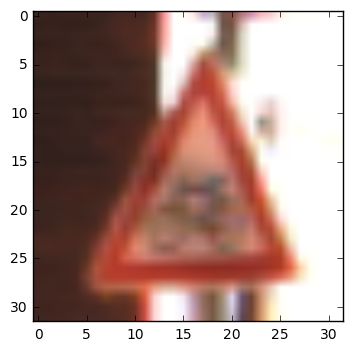


Example image with feature called out: 
location:  [ 5  5 51 53]
type:  42


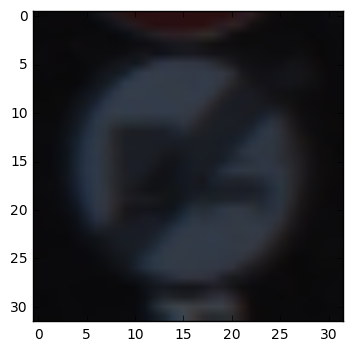

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import floor, ceil

widths = list(map(lambda x: x[0], train['sizes']))
heights = list(map(lambda x: x[1], train['sizes']))

# labels
plt.hist(train['labels'], len(set(train['labels'])))
plt.title("labels")
plt.grid(True)
plt.show()
label_counts = np.bincount(train['labels'])
print(label_counts)
print("mean label count: ", np.average(label_counts))
print("median label count: ", np.median(label_counts))

# plot histograms
plt.hist(widths)
plt.title("widths")
plt.grid(True)
plt.show()
print("min image width", min(widths))
print("max image width", max(widths))
print("")

plt.hist(heights)
plt.title("heights")
plt.grid(True)
plt.show()

print("min image height", min(heights))
print("max image height", max(heights))
print("")

    
print("There doesn't seem to be much reason to have the coords of the feature in the original image at this point...")
print("")

for i in range(0, len(widths), floor(len(widths)/5)):
    print("Example image with feature called out: ")
    print("location: ", train["coords"][i])
    print("type: ", train['labels'][i])
    image = X_train[i].copy()
#     coords1 = tuple(train["coords"][i][:2])
#     coords2 = tuple(train["coords"][i][2:])
#     image_with_lines = cv2.rectangle(image, coords1, coords2, color=[255, 0, 0], thickness=1)
#     plt.imshow(image_with_lines)
    plt.imshow(image)
    plt.show()
    print("")


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def get_channel_means(image):
    b_mean = np.mean(image[:,:,0])
    g_mean = np.mean(image[:,:,1])
    r_mean = np.mean(image[:,:,2])
    return np.array([b_mean, g_mean, r_mean])

def get_channel_std_dev(image):
    b_std = np.std(image[:,:,0])
    g_std = np.std(image[:,:,1])
    r_std = np.std(image[:,:,2])
    return np.array([b_std, g_std, r_std])

def rescale_colors(images):
    # recales RBG values from 0-255 to 0-1
    return np.divide(images, 255)

def greyscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def color_standardize(image):
    # subtracting the per-image mean from each channel effectively removes luminosity, which we don't care about 
    # dividing by the std_dev scales the input to have a standard deviation of 1
    means = get_channel_means(image)
    std_dev = get_channel_std_dev(image)
    image = np.subtract(image, means)
    return np.divide(image, std_dev)

def grey_standardize(image):
    grey_image = greyscale(image)
    mean = np.mean(grey_image)
    std_dev = np.std(grey_image)
    zero_mean_image = np.subtract(grey_image, mean)
    scaled_image = np.divide(zero_mean_image, std_dev)
    return scaled_image
    
# print(X_train[0])
color_image = X_train[0].copy()
grey_image = greyscale(X_train[0].copy())

print("---- COLOR STANDARDIZE ----")
print("preprocess means: ", get_channel_means(color_image))
print("preprocess std's: ", np.std(color_image[:,:,0]), np.std(color_image[:,:,1]), np.std(color_image[:,:,2]))
print("preprocess min:", np.amin(color_image))
print("preprocess max:", np.amax(color_image))
print("")
color_image = color_standardize(color_image)
print("standardized means: ", get_channel_means(color_image))
print("standardized std's: ", np.std(color_image[:,:,0]), np.std(color_image[:,:,1]), np.std(color_image[:,:,2]))
print("standardized min:", np.amin(color_image))
print("standardized max:", np.amax(color_image))
print("")

print("---- GREY STANDARDIZE ----")
print("preprocess means: ", np.mean(grey_image))
print("preprocess std: ", np.std(grey_image))
print("preprocess min:", np.amin(grey_image))
print("preprocess max:", np.amax(grey_image))
print("")

grey_image = grey_standardize(X_train[0].copy())
print("standardized means: ", np.mean(grey_image))
print("standardized std: ", np.std(grey_image))

print("standardized min:", np.amin(grey_image))
print("standardized max:", np.amax(grey_image))

# the horror!
# plt.imshow(images[0])
# plt.show()

---- COLOR STANDARDIZE ----
preprocess means:  [ 142.25488281  120.69824219  122.82910156]
preprocess std's:  49.3252961414 42.535070053 47.5650366108
preprocess min: 53
preprocess max: 255

standardized means:  [  0.00000000e+00   3.46944695e-18   2.08166817e-17]
standardized std's:  1.0 1.0 1.0
standardized min: -1.60677966505
standardized max: 3.11041589088

---- GREY STANDARDIZE ----
preprocess means:  123.784179688
preprocess std:  43.1379204344
preprocess min: 67
preprocess max: 254

standardized means:  1.38777878078e-17
standardized std:  1.0
standardized min: -1.31634022029
standardized max: 3.01859289927


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

After googling around for various sources, it seems like the most common way to preprocess images for CNN's is to give each color channel in each image a mean of zero. This is accomplished by taking the mean then subtracting that from every value. This is done for each color channel in each image. I also read that it is common to scale the color channel by dividing each by its standard deviation. This is opposed to a more obvious method of scaling, which is just reduce the range from (0,255) to (0,1). 

I implemented helper functions for the above manipulations for color, then later for greyscale images. I originally intended to train the network on color images because it would intuitively seem like color would be a valuable signal for the network to have. However after reading "Traffic Sign Recognition with Multi-Scale Convolutional Networks" by Sermanet & LeCun, it turns out that greyscale images lead to more accurate classification.

In [17]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import ShuffleSplit

BATCH_SIZE = 512
batches_in_set = len(y_train) // BATCH_SIZE
splitter = ShuffleSplit(n_splits=batches_in_set, test_size=BATCH_SIZE, train_size=BATCH_SIZE)
# actual splitting is done in a later cell

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

This part was pretty easy thanks to scikit learn. I used the ShuffleSplit class to shuffle my training data then split it into training and validation sets. Testing data has already been set aside for us (see './traffic-signs-data/test.p')

In [35]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

# TODO: pull outs weights from individual functions, make them globally accessible

CLASSES_LEN = 43
DEBUG = False

def get_depth(input_tensor):
    if(input_tensor.get_shape):
        return input_tensor.get_shape().as_list()[-1]
    else:
        raise TypeError('get_depth must be passed a Tensor')

def convolution_helper(input_tensor, output_depth, kernel_height=1, kernel_width=1):
    input_depth = get_depth(input_tensor)
#     weight = tf.Variable(tf.truncated_normal([kernel_height, kernel_width, input_depth, output_depth]))
#     bias = tf.Variable(tf.zeros(output_depth))
    weight = tf.get_variable(
        'weights',
        [kernel_height, kernel_width, input_depth, output_depth],
        initializer=tf.random_normal_initializer()
    )
    bias = tf.get_variable(
        'bias',
        output_depth,
        initializer=tf.random_uniform_initializer(-0.5, 0.5)
    )
    conv = tf.nn.conv2d(input_tensor, weight, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_bias = tf.nn.bias_add(conv, bias)
    output_tensor = tf.nn.relu(conv_with_bias)
    
    return output_tensor

def convolution(input_tensor, output_depth, kernel_size):
    # implements asymmetric convolutions which are more efficient
    
    if(kernel_size % 2 == 0):
        raise ValueError('convolution only accepts odd kernel sizes')
        
    if(kernel_size == 1):
        return convolution_helper(input_tensor, output_depth, 1, 1)
    
    output_tensor = input_tensor
    for i in range(0, kernel_size // 2):  # 3x3 -> 1 loop, 5x5 -> 2 loops, 7x7 -> 3 loops
        with tf.variable_scope("1x3_conv_" + str(i)):
            output_tensor = convolution_helper(output_tensor, output_depth, 1, 3)
        with tf.variable_scope("3x1_conv_" + str(i)):
            output_tensor = convolution_helper(output_tensor, output_depth, 3, 1)

    return output_tensor

def inception(input_tensor, output_depth):
    # components are 1x1, 3x3 reduce, 3x3, 5x5 reduce, 5x5, pool, pool reduce
    if(output_depth % 4 != 0):
        raise ValueError('output_depth must be divisible by 4')
    # TODO double check this math
    middle_layer_depth = round(output_depth * (2/3)) # hyperparameter borrowed from GoogLeNet
    partial_output_depth = output_depth // 4 # hyperparameter
    
    if(DEBUG == True):
        print('output_depth', output_depth)
        print('middle_layer_depth', middle_layer_depth)
        print('partial_output_depth', partial_output_depth)
    
    # initial layers
    with tf.variable_scope("3x3_conv_reduce"):
        three_by_three_reduce = convolution(input_tensor, middle_layer_depth, 1)
    with tf.variable_scope("5x5_conv_reduce"):
        five_by_five_reduce = convolution(input_tensor, middle_layer_depth, 1)
    pool = tf.nn.max_pool(
        input_tensor,
        ksize=[1, 1, 1, 1],
        strides=[1, 1, 1, 1],
        padding='VALID'
    )
    
    # each component has the same output depth
    with tf.variable_scope("1x1_conv"):
        one_by_one = convolution(input_tensor, partial_output_depth, 1)
    with tf.variable_scope("3x3_conv"):
        three_by_three = convolution(three_by_three_reduce, partial_output_depth, 3)
    with tf.variable_scope("5x5_conv"):
        five_by_five = convolution(five_by_five_reduce, partial_output_depth, 5)
    with tf.variable_scope("pool_reduce"):
        pool_reduce = convolution(pool, partial_output_depth, 1)
    
    if(DEBUG == True):
        print('')
        print('1x1 shape', one_by_one.get_shape())
        print('3x3 shape', three_by_three.get_shape())
        print('5x5 shape', five_by_five.get_shape())
        print('pool shape', pool_reduce.get_shape())

    # concat on depth dimension
    depth_concat = tf.concat(3, [one_by_one, three_by_three, five_by_five, pool_reduce])
    
    return depth_concat

    
    

def davenet(input):
    # TODO: add dropout, local normalization
    
    # Step 1: Reshape
    # -1 tells tf to infer that dimension (batch size) given the other dimensions
    step_1 = tf.reshape(input, (-1, 32, 32, 1))
    
    # Step 2: 3x3 Convolution -> 32x32x32
    with tf.variable_scope("3x3_conv_1"):
        step_2 = convolution(step_1, 32, 3)
    
    
    # Step 3: 3x3 Convolution w/ 2x2 avg pool -> 16x16x64
    with tf.variable_scope("3x3_conv_2"):
        step_3 = convolution(step_2, 64, 3)
        step_3 = tf.nn.avg_pool(
            step_3,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='VALID'
        )
    
    
    # Step 4: Inception w/ 2x2 avg pool -> 8x8x128
    with tf.variable_scope("inception_1"):
        step_4 = inception(step_3, 128)
        step_4 = tf.nn.avg_pool(
            step_4,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='VALID'
        )
    
    
    # Step 5: Inception w/ 2x2 avg pool -> 4x4x256
    with tf.variable_scope("inception_2"):
        step_5 = inception(step_4, 256)
        step_5 = tf.nn.avg_pool(
            step_5,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='VALID'
        )
        
        
    # Step 6: Fully Connected Layer -> 1x43
    step_6 = flatten(step_5) # -> 1x4096
    step_6_shape = (get_depth(step_6), CLASSES_LEN)
    with tf.variable_scope("fully_connected"):
        step_6_weight = tf.get_variable(
            'weights',
            step_6_shape,
            initializer=tf.random_normal_initializer()
        )
        step_6_bias = tf.get_variable(
            'bias',
            CLASSES_LEN,
            initializer=tf.random_uniform_initializer(-0.5, 0.5)
        )
#         step_6_weight = tf.Variable(tf.truncated_normal(shape=step_6_shape))
#         step_6_bias = tf.Variable(tf.zeros(CLASSES_LEN))
        step_6 = tf.matmul(step_6, step_6_weight)
        step_6 = tf.nn.bias_add(step_6, step_6_bias)
        step_6 = tf.nn.relu(step_6)
    
    return step_6



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

I decided to implement something resembling GoogleNet's architecture. It starts with two 3x3 convolutional layers with ReLu activations, followed by a 2x2 average pool, then two layers of inception module + 2x2 average pools. The inception modules use asymmetrical convolutions (3x3 == 1x3, 3x1) as well as convolution factorization (5x5 == 3x3, 3x3) to improve the efficiency of the operation. This is then followed by a fully connected layer which flattens and reduces the output to 1x43, which is the number of classes the dataset has. 


**Answer:**

In [36]:
### Train your model here.
### Feel free to use as many code cells as needed.
tf.reset_default_graph()

# Dataset consists of 32x32x1, grayscale images
x = tf.placeholder(tf.float32, (None, 32, 32))
# Classify over 43 classes of traffic sign
y = tf.placeholder(tf.float32, (None, 43))
# with tf.variable_scope('davenet'):
net = davenet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, y))
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

EPOCHS = 5


def index_to_array(idx, array_size):
    # converts an int to an array of 0's with that idx set to 1
    arr = np.zeros(array_size)
    arr[idx] = 1
    return arr

def eval_data():
    print('eval data')
    testing_sets = splitter.split(X_test, y_test)
    testing_sets = iter(testing_sets)
    steps_per_epoch = len(y_test) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(30):
        batch_x_indexes, batch_y_indexes = next(testing_sets)
        batch_x = list(map(lambda i: grey_standardize(X_test[i]), batch_x_indexes))
        batch_y = list(map(lambda i: index_to_array(y_test[i], CLASSES_LEN), batch_y_indexes))
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_acc += (acc * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples, total_acc/num_examples

with tf.Session() as sess:
    file_writer = tf.summary.FileWriter('/Users/david/Desktop/tflogs/', sess.graph)
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(y_train) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE

    # Train model
    for i in range(EPOCHS):
        print('epoch ', i)
        training_sets = splitter.split(X_train, y_train)
        training_sets = iter(training_sets)
        
        for step in range(30):
#             print('step ', step)
            batch_x_indexes, batch_y_indexes = next(training_sets)
            batch_x = list(map(lambda i: grey_standardize(X_train[i]), batch_x_indexes))
            batch_y = list(map(lambda i: index_to_array(y_train[i], CLASSES_LEN), batch_y_indexes))
#             print('batch_x_indexes', len(batch_x_indexes))
#             print('batch_y_indexes', len(batch_y_indexes))
#             print('steps_per_epoch', steps_per_epoch)
#             print('num examples', num_examples)
#             print('batch len', len(batch_x))
#             print('model training')
            loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})

        val_loss, val_acc = eval_data()
        print("EPOCH {} ...".format(i+1))
        print("Validation loss = {:.3f}".format(val_loss))
        print("Validation accuracy = {:.3f}".format(val_acc))
        print()

    # Evaluate on the test data
#     test_loss, test_acc = eval_data()
#     print("Test loss = {:.3f}".format(test_loss))
#     print("Test accuracy = {:.3f}".format(test_acc))

epoch  0
eval data
EPOCH 1 ...
Validation loss = 4285303215445.333
Validation accuracy = 0.046

epoch  1
eval data
EPOCH 2 ...
Validation loss = 1731299748522.667
Validation accuracy = 0.042

epoch  2
eval data
EPOCH 3 ...
Validation loss = 885091207850.667
Validation accuracy = 0.039

epoch  3
eval data
EPOCH 4 ...
Validation loss = 313742503936.000
Validation accuracy = 0.029

epoch  4
eval data
EPOCH 5 ...
Validation loss = 33283045589.333
Validation accuracy = 0.010



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.